In [156]:
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scorecardpy as sc

In [157]:
# Set theme to "whitegrid"
sns.set_style("whitegrid")

# Make custom color palette from list of colors
PLOT_COLORS = [
    "#F72585",
    "#B5179E",
    "#7209B7",
    "#560BAD",
    "#480CA8",
    "#3A0CA3",
    "#3F37C9",
    "#4361EE",
    "#4895EF",
    "#4CC9F0",
]

custom_palette = sns.color_palette(PLOT_COLORS)

# Silence seaborn FutureWarning and UserWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


def get_color(i: int) -> str:
    return PLOT_COLORS[i % len(PLOT_COLORS)]

In [158]:
df: pd.DataFrame = pd.read_excel("../data/kredyty_auto_Scoring2025s.xlsx")

df.head()

,LP,data_akceptacji,grupa_ryzyka,kod_partnera,typ_umowy,scoring_FICO,okres_kredytu,kwota_kredytu,oproc_refin,oproc_konkur,koszt_pieniadza,oproc_propon,akceptacja_klienta
0,1,2005-04-17,2,2,R,702,48,26500.00,0.0399,0.0499,0.011,0.0659,0
1,2,2005-04-17,2,2,N,719,72,34999.99,0.0000,0.0479,0.011,0.0599,0
2,3,2005-04-17,1,3,N,802,60,28000.00,0.0000,0.0399,0.011,0.0355,0
3,4,2005-04-17,1,1,R,723,60,20750.69,0.0675,0.0499,0.011,0.0489,1
4,5,2005-04-17,3,1,U,690,72,19999.99,0.0000,0.0529,0.011,0.0679,0


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   LP                  40000 non-null  int64         
 1   data_akceptacji     40000 non-null  datetime64[ns]
 2   grupa_ryzyka        40000 non-null  int64         
 3   kod_partnera        40000 non-null  int64         
 4   typ_umowy           40000 non-null  object        
 5   scoring_FICO        40000 non-null  int64         
 6   okres_kredytu       40000 non-null  int64         
 7   kwota_kredytu       40000 non-null  float64       
 8   oproc_refin         40000 non-null  float64       
 9   oproc_konkur        40000 non-null  float64       
 10  koszt_pieniadza     40000 non-null  float64       
 11  oproc_propon        40000 non-null  float64       
 12  akceptacja_klienta  40000 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(6), ob

In [129]:
TARGET = "akceptacja_klienta"

EXCLUDED_FEATURES = ["LP", "data_akceptacji"]

Zmienne pochodne

In [161]:
def calculate_annuit_rate(row):
    percentage = row["oproc_propon"]
    n = row["okres_kredytu"]

    if (
        pd.isnull(row["kwota_kredytu"])
        or pd.isnull(percentage)
        or pd.isnull(n)
        or n == 0
    ):
        return None  # obsługa braków danych lub dzielenia przez zero

    r = percentage / 12  # miesięczna stopa procentowa jako ułamek

    rata = row["kwota_kredytu"] * (r * (1 + r) ** n) / ((1 + r) ** n - 1)
    return rata


df["rata_annuita"] = df.apply(calculate_annuit_rate, axis=1)

In [162]:
df["delta_oproc_konkurencji"] = df["oproc_propon"] - df["oproc_konkur"]
df["delta_oproc_refinansowana"] = df["oproc_propon"] - df["oproc_refin"]

In [163]:
df["is_n"] = df.apply(lambda row: 1 if row["typ_umowy"] == "N" else 0, axis=1)
df["is_r"] = df.apply(lambda row: 1 if row["typ_umowy"] == "R" else 0, axis=1)

Statystyki opisowe

In [164]:
filtered_columns = df.select_dtypes(include=["number"]).columns.difference(
    EXCLUDED_FEATURES
)

non_binary_columns = [col for col in filtered_columns if df[col].nunique() > 2]

df[non_binary_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
delta_oproc_konkurencji,40000.0,0.016236,0.019731,-0.016400,0.000000,0.012000,0.031500,0.077600
delta_oproc_refinansowana,40000.0,0.042223,0.045108,-0.195400,0.014400,0.048900,0.071900,0.112500
grupa_ryzyka,40000.0,2.053725,1.090307,1.000000,1.000000,2.000000,3.000000,4.000000
kod_partnera,40000.0,2.103425,0.912825,1.000000,1.000000,2.000000,3.000000,3.000000
koszt_pieniadza,40000.0,0.014169,0.002618,0.010900,0.011138,0.013800,0.016300,0.021010
kwota_kredytu,40000.0,24211.651536,11211.386637,4526.620000,15703.592500,23000.000000,30906.825000,100000.000000
okres_kredytu,40000.0,57.186900,11.386207,36.000000,48.000000,60.000000,60.000000,72.000000
oproc_konkur,40000.0,0.049631,0.005794,0.029900,0.044900,0.049900,0.053900,0.062900
oproc_propon,40000.0,0.065867,0.020704,0.025900,0.048200,0.063400,0.082400,0.113500
oproc_refin,40000.0,0.023644,0.041133,0.000000,0.000000,0.000000,0.055000,0.240000


In [165]:
md = df[non_binary_columns].describe().T

print(md.to_markdown(floatfmt=".3f"))

|                           |     count |      mean |       std |      min |       25% |       50% |       75% |        max |
|:--------------------------|----------:|----------:|----------:|---------:|----------:|----------:|----------:|-----------:|
| delta_oproc_konkurencji   | 40000.000 |     0.016 |     0.020 |   -0.016 |     0.000 |     0.012 |     0.031 |      0.078 |
| delta_oproc_refinansowana | 40000.000 |     0.042 |     0.045 |   -0.195 |     0.014 |     0.049 |     0.072 |      0.113 |
| grupa_ryzyka              | 40000.000 |     2.054 |     1.090 |    1.000 |     1.000 |     2.000 |     3.000 |      4.000 |
| kod_partnera              | 40000.000 |     2.103 |     0.913 |    1.000 |     1.000 |     2.000 |     3.000 |      3.000 |
| koszt_pieniadza           | 40000.000 |     0.014 |     0.003 |    0.011 |     0.011 |     0.014 |     0.016 |      0.021 |
| kwota_kredytu             | 40000.000 | 24211.652 | 11211.387 | 4526.620 | 15703.592 | 23000.000 | 30906.825 | 10000

Rozkłady zmiennych

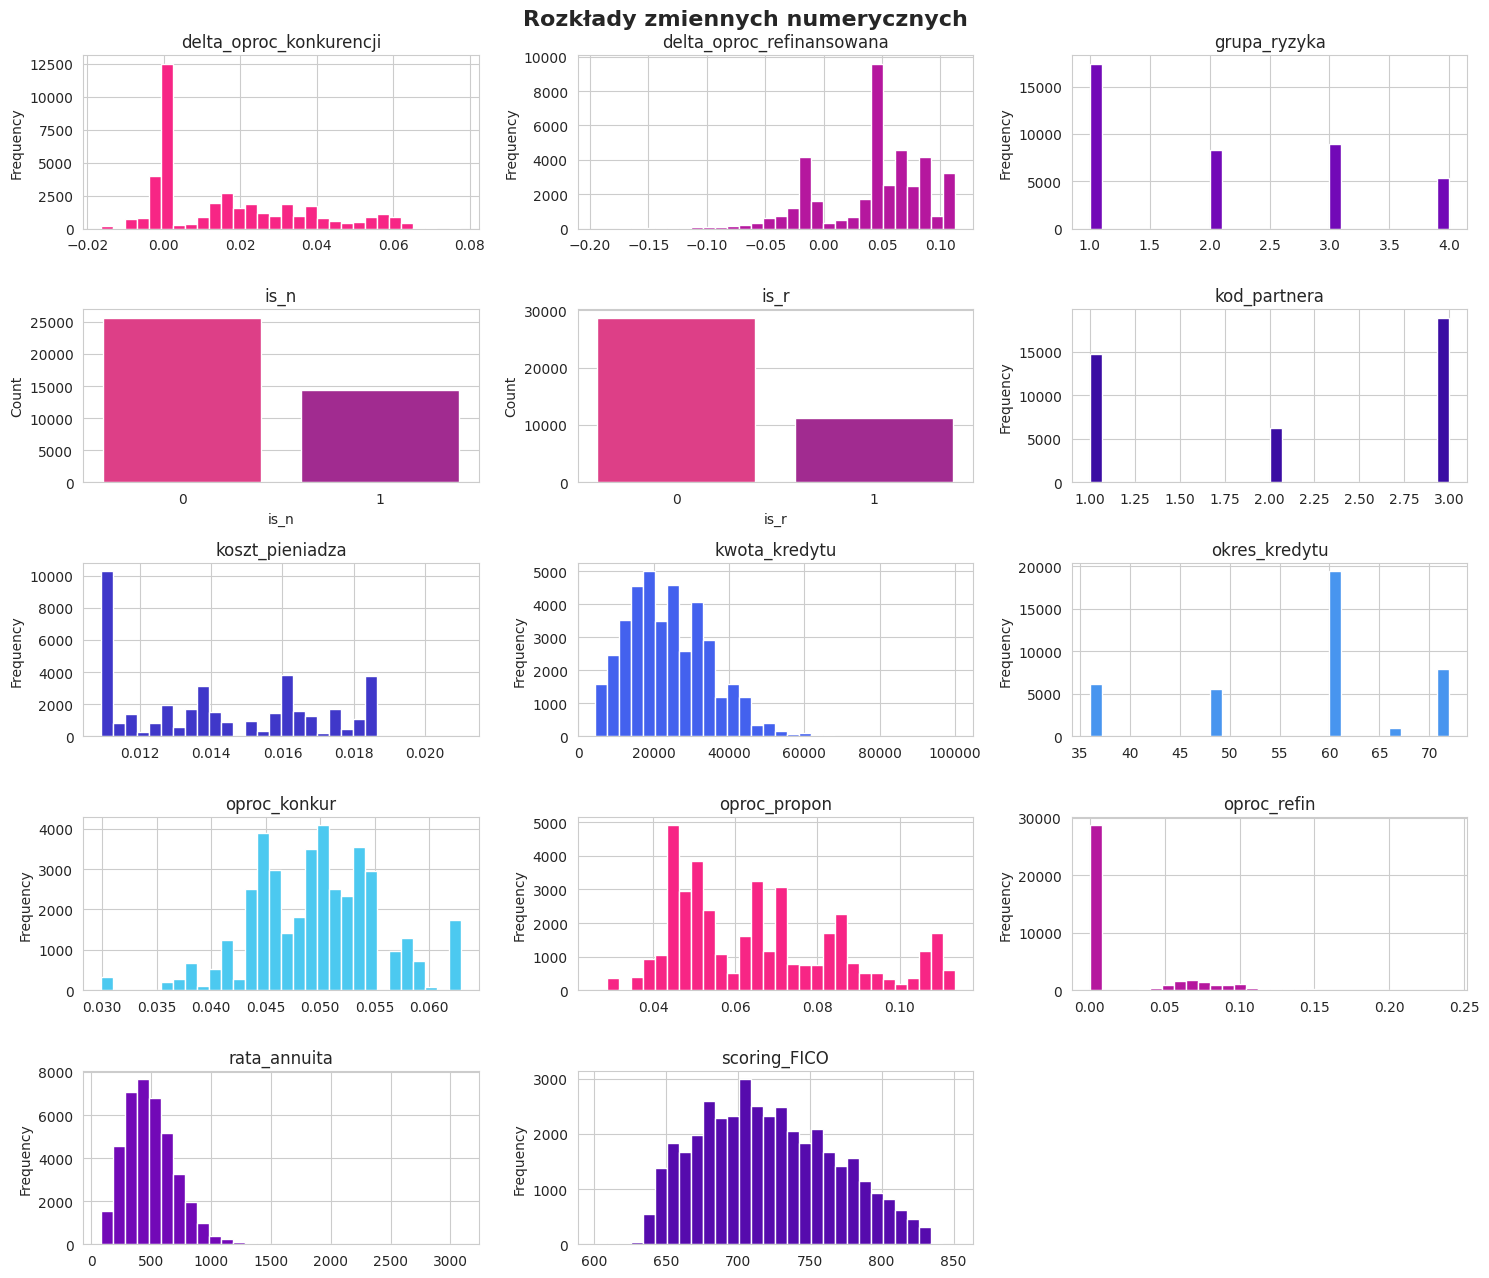

In [166]:
# Select numeric columns excluding those in EXCLUDED_FEATURES
numeric_columns = df.select_dtypes(include=["number"]).columns.difference(
    EXCLUDED_FEATURES + [TARGET]
)

# Set up the subplot grid
num_cols = 3
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 13))
axes = axes.flatten()

fig.subplots_adjust(hspace=0.5)

fig.suptitle("Rozkłady zmiennych numerycznych", fontsize=16, fontweight="bold")

# Plot histograms or bar plots
for i, col in enumerate(numeric_columns):
    ax = axes[i]
    if df[col].nunique() == 2:  # Use bar plot for binary variables
        value_counts = df[col].value_counts()
        sns.barplot(
            x=value_counts.index, y=value_counts.values, ax=ax, palette=custom_palette
        )
        ax.set_ylabel("Count")
    else:  # Use histogram for non-binary variables
        bins = 30
        df[col].hist(bins=bins, ax=ax, color=get_color(i))
        ax.set_ylabel("Frequency")
    ax.set_title(f"{col}")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

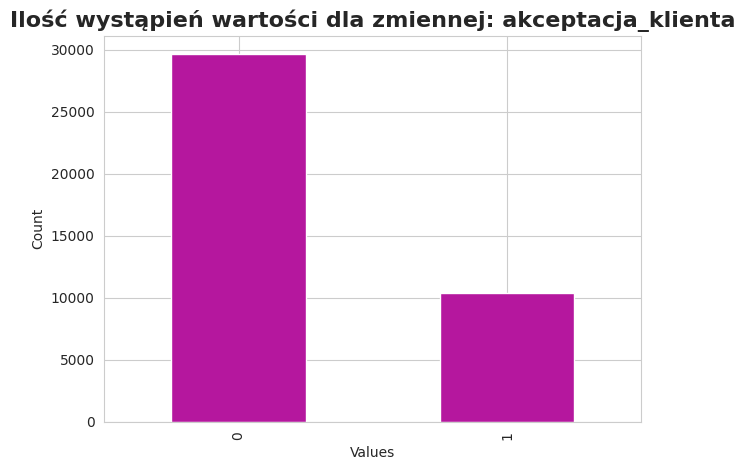

In [167]:
# Plot value counts for the target variable
target_value_counts = df[TARGET].value_counts()
target_value_counts.plot(kind="bar", color=get_color(1))

plt.title(
    f"Ilość wystąpień wartości dla zmiennej: {TARGET}", fontsize=16, fontweight="bold"
)
plt.ylabel("Count")
plt.xlabel("Values")
plt.tight_layout()
plt.show()

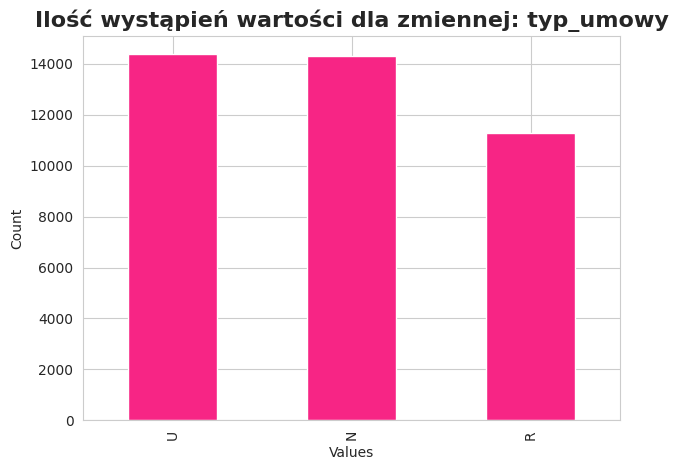

In [168]:
# Select the descriptive (non-numeric) variable
descriptive_column = "typ_umowy"

# Plot value counts for the descriptive variable
value_counts = df[descriptive_column].value_counts()
value_counts.plot(kind="bar", color=get_color(0))

plt.title(
    f"Ilość wystąpień wartości dla zmiennej: {descriptive_column}",
    fontsize=16,
    fontweight="bold",
)
plt.ylabel("Count")
plt.xlabel("Values")
plt.tight_layout()
plt.show()


Siły predykcyjne

In [169]:
def compute_woe_iv(
    df: pd.DataFrame, feature: str, target: str, bins: int = 10
) -> float:
    """Compute Information Value for a single feature."""
    series = df[feature]

    if pd.api.types.is_numeric_dtype(series):
        binned = pd.qcut(series, bins, duplicates="drop")
    else:
        binned = series.astype("object")

    tmp = pd.DataFrame({feature: binned, target: df[target]})
    grp = tmp.groupby(feature, observed=False)[target].agg(["count", "sum"])
    grp["non_event"] = grp["count"] - grp["sum"]

    grp["dist_event"] = grp["sum"] / grp["sum"].sum()
    grp["dist_non_event"] = grp["non_event"] / grp["non_event"].sum()

    grp = grp[(grp["dist_event"] > 0) & (grp["dist_non_event"] > 0)]
    grp["woe"] = np.log(grp["dist_event"] / grp["dist_non_event"])
    iv = ((grp["dist_event"] - grp["dist_non_event"]) * grp["woe"]).sum()
    return float(iv)


def cramers_v(x: pd.Series, y: pd.Series) -> float:
    """Compute Cramer's V statistic for association between two categorical series."""
    contingency = pd.crosstab(x, y)
    chi2, _, _, _ = stats.chi2_contingency(contingency)
    n = contingency.values.sum()
    phi2 = chi2 / n
    r, k = contingency.shape
    return float(np.sqrt(phi2 / min(k - 1, r - 1)))

In [132]:
# run over all predictors
features = [c for c in df.columns if c not in EXCLUDED_FEATURES + [TARGET]]
iv_list = []
cv_list = []
for f in features:
    try:
        iv_list.append({"feature": f, "IV": compute_woe_iv(df, f, TARGET)})
        cv_list.append({"feature": f, "CramersV": cramers_v(df[f], df[TARGET])})
    except Exception as e:
        print(f"skipping {f}: {e}")

iv_df = pd.DataFrame(iv_list).sort_values("IV", ascending=False).reset_index(drop=True)
cv_df = (
    pd.DataFrame(cv_list)
    .sort_values("CramersV", ascending=False)
    .reset_index(drop=True)
)

In [131]:
iv_df

,feature,IV
0,rata_annuita,1.005477
1,kwota_kredytu,0.942273
2,delta_oproc_refinansowana,0.533540
3,oproc_refin,0.283355
4,delta_oproc_konkurencji,0.231183
5,oproc_konkur,0.213204
6,oproc_propon,0.210357
7,grupa_ryzyka,0.107380
8,scoring_FICO,0.084846
9,okres_kredytu,0.064450


In [172]:
cv_df

,feature,CramersV
0,rata_annuita,0.960104
1,kwota_kredytu,0.858116
2,delta_oproc_refinansowana,0.444690
3,delta_oproc_konkurencji,0.322121
4,oproc_propon,0.313878
5,oproc_refin,0.298565
6,typ_umowy,0.265231
7,oproc_konkur,0.243613
8,is_n,0.239631
9,is_r,0.212574


In [173]:
X = df[features].apply(lambda col: pd.factorize(col, sort=True)[0])
y = df[TARGET].astype(int)

mi = mutual_info_classif(X, y, discrete_features="auto", random_state=42)
mi_df = pd.DataFrame({"feature": features, "MI": mi}).sort_values("MI", ascending=False)

mi_df

,feature,MI
5,kwota_kredytu,0.158065
10,rata_annuita,0.131846
12,delta_oproc_refinansowana,0.074487
9,oproc_propon,0.048835
11,delta_oproc_konkurencji,0.042202
2,typ_umowy,0.038418
13,is_n,0.033307
7,oproc_konkur,0.032108
6,oproc_refin,0.031750
14,is_r,0.026033


Odpalanko części drugiej testy bombowe

In [ ]:
# Wylaczenie zmiennych ktore maja mniej niz 0.1 IV
EXCLUDED_FEATURES = EXCLUDED_FEATURES + iv_df[iv_df["IV"] < 0.1]["feature"].to_list()
features = [c for c in df.columns if c not in EXCLUDED_FEATURES + [TARGET]]

In [100]:
df_filtered = df[features + [TARGET]].copy()

In [101]:
train, test = sc.split_df(df_filtered, TARGET, ratio=0.8, seed=42).values()

len(train), len(test)

(32000, 8000)

In [133]:
train

,grupa_ryzyka,typ_umowy,kwota_kredytu,oproc_refin,oproc_konkur,oproc_propon,delta_oproc_konkurencji,delta_oproc_refinansowana,rata_annuita,akceptacja_klienta
0,2,R,26500.00,0.0399,0.0499,0.0659,0.0160,0.0260,629.546841,0
1,2,N,34999.99,0.0000,0.0479,0.0599,0.0120,0.0599,579.885709,0
2,1,N,28000.00,0.0000,0.0399,0.0355,-0.0044,0.0355,509.996065,0
3,1,R,20750.69,0.0675,0.0499,0.0489,-0.0010,-0.0186,390.546232,1
4,3,U,19999.99,0.0000,0.0529,0.0679,0.0150,0.0679,338.966765,0
...,...,...,...,...,...,...,...,...,...,...
39993,3,N,34999.99,0.0000,0.0509,0.0875,0.0366,0.0875,626.559681,0
39994,3,U,16000.00,0.0000,0.0479,0.0865,0.0386,0.0865,329.422425,0
39995,3,U,21000.00,0.0000,0.0479,0.0865,0.0386,0.0865,432.366933,0
39997,1,N,27000.00,0.0000,0.0439,0.0439,0.0000,0.0439,502.012145,0


In [102]:
bins = sc.woebin(
    df_filtered,
    y=TARGET,
)

[INFO] creating woe binning ...


/Users/kacperkedzierski/Documents/Code/Repositories/scoring-project/.venv/lib/python3.12/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/kacperkedzierski/Documents/Code/Repositories/scoring-project/.venv/lib/python3.12/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/kacperkedzierski/Documents/Code/Repositories/scoring-project/.venv/lib/python3.12/site-packages/scorecardpy/woebin.py:414

In [103]:
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [106]:
y_train = train_woe[TARGET]
X_train = train_woe.drop(columns=[TARGET])

y_test = test_woe[TARGET]
X_test = test_woe.drop(columns=[TARGET])

In [119]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    penalty="l2",
    C=0.01,
    solver="liblinear",
    max_iter=10000,
    random_state=42,
)
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=10000, random_state=42, solver='liblinear')

In [120]:
train_pred = lr.predict_proba(X_train)[:, 1]
test_pred = lr.predict_proba(X_test)[:, 1]

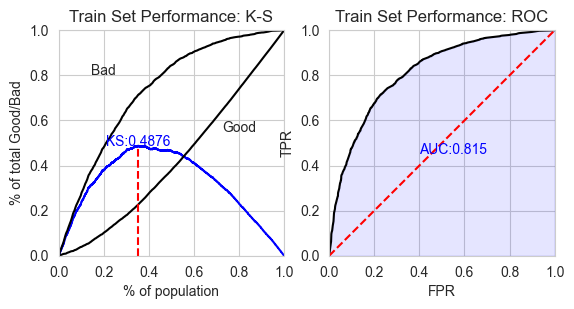

In [121]:
train_perf = sc.perf_eva(
    y_train,
    train_pred,
    title="Train Set Performance",
)

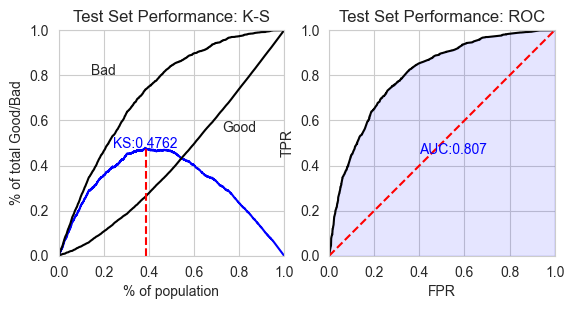

In [122]:
test_perf = sc.perf_eva(
    y_test,
    test_pred,
    title="Test Set Performance",
)

In [ ]:
"""
    Nasza karta bedzie skalibrowana nastepujaco:
    Szansa 1/4 - 20% prawdopodobienstwa akceptacji oferty bedzie dla 100 pkt
    Ilosc punktow do zwiekszenia szans ustawimy na 50 pkt
"""
card = sc.scorecard(bins, lr, X_train.columns, points0=100, odds0=1 / 4, pdo=50)

Scorecard

In [134]:
card

{'basepoints':      variable  bin  points
 0  basepoints  NaN    75.0,
 'oproc_refin':       variable           bin  points
 0  oproc_refin  [-inf,0.065)     3.0
 1  oproc_refin   [0.065,0.1)    -9.0
 2  oproc_refin     [0.1,inf)   -15.0,
 'rata_annuita':        variable            bin  points
 3  rata_annuita   [-inf,280.0)   -52.0
 4  rata_annuita  [280.0,420.0)   -19.0
 5  rata_annuita  [420.0,460.0)     3.0
 6  rata_annuita  [460.0,600.0)    24.0
 7  rata_annuita    [600.0,inf)    52.0,
 'grupa_ryzyka':         variable         bin  points
 8   grupa_ryzyka  [-inf,2.0)   -24.0
 9   grupa_ryzyka   [2.0,3.0)    15.0
 10  grupa_ryzyka   [3.0,inf)    27.0,
 'delta_oproc_refinansowana':                      variable                                            bin  \
 11  delta_oproc_refinansowana                   [-inf,-0.024999999999999883)   
 12  delta_oproc_refinansowana  [-0.024999999999999883,-0.004999999999999866)   
 13  delta_oproc_refinansowana    [-0.004999999999999866,0.0450

In [124]:
card_df = pd.concat(card)

card_df.index.names = ["card_section", "original_index"]
card_df

variable  \
card_section              original_index                              
basepoints                0                              basepoints   
oproc_refin               0                             oproc_refin   
                          1                             oproc_refin   
                          2                             oproc_refin   
rata_annuita              3                            rata_annuita   
                          4                            rata_annuita   
                          5                            rata_annuita   
                          6                            rata_annuita   
                          7                            rata_annuita   
grupa_ryzyka              8                            grupa_ryzyka   
                          9                            grupa_ryzyka   
                          10                           grupa_ryzyka   
delta_oproc_refinansowana 11              delta_oproc_refinansowana   
                          12              delta_oproc_refinansowana   
                          13              delta_oproc_refinansowana   
                          14              delta_oproc_refinansowana   
                          15              delta_oproc_refinansowana   
delta_oproc_konkurencji   16                delta_oproc_konkurencji   
                          17                delta_oproc_konkurencji   
                          18                delta_oproc_konkurencji   
kwota_kredytu             19                          kwota_kredytu   
                          20                          kwota_kredytu   
                          21                          kwota_kredytu   
                          22                          kwota_kredytu   
                          23                          kwota_kredytu   
oproc_propon              24                           oproc_propon   
                          25                           oproc_propon   
                          26                           oproc_propon   
                          27                           oproc_propon   
typ_umowy                 28                              typ_umowy   
                          29                              typ_umowy   
                          30                              typ_umowy   
oproc_konkur              31                           oproc_konkur   
                          32                           oproc_konkur   
                          33                           oproc_konkur   
                          34                           oproc_konkur   

                                                                                    bin  \
card_section              original_index                                                  
basepoints                0                                                         NaN   
oproc_refin               0                                                [-inf,0.065)   
                          1                                                 [0.065,0.1)   
                          2                                                   [0.1,inf)   
rata_annuita              3                                                [-inf,280.0)   
                          4                                               [280.0,420.0)   
                          5                                               [420.0,460.0)   
                          6                                               [460.0,600.0)   
                          7                                                 [600.0,inf)   
grupa_ryzyka              8                                                  [-inf,2.0)   
                          9                                                   [2.0,3.0)   
                          10                                                  [3.0,inf)   
delta_oproc_refinansowana 11                               [-inf,-0.024999999999999883

In [197]:
train_score = sc.scorecard_ply(
    train,
    card,
)

train_score

,score
0,153.0
1,148.0
2,75.0
3,15.0
4,73.0
...,...
39993,232.0
39994,97.0
39995,149.0
39997,117.0


In [198]:
test_score = sc.scorecard_ply(
    test,
    card,
)

test_score

,score
6,-67.0
12,122.0
14,180.0
16,180.0
20,216.0
...,...
39974,117.0
39983,-11.0
39988,71.0
39996,270.0


**Funkcja pomocniczna obliczająca ocenę punktową**

In [ ]:
import pandas as pd
import numpy as np  # noqa


def generate_scoring_function_string(card: dict) -> str:
    # Base function string, imports and function definition ...
    # NEEDS TO BE List of strings because multiline strings break indentation!!
    function_string_parts = [
        "import pandas as pd",
        "import numpy as np",
        "",
        "def score_dataframe(df: pd.DataFrame) -> pd.DataFrame:",
        '    """Applies the scorecard logic to a DataFrame to calculate scores."""',
        "    df_scored = df.copy() # Use a copy to avoid modifying the original DataFrame",
        "",
        "    # Define helper function for rata_annuita",
        "    # NOTE: Renamed from calculate_annuit_rate_internal to avoid confusion!",
        "    def calculate_annuit_rate_internal(row):",
        '        percentage = row.get("oproc_propon")',
        '        n = row.get("okres_kredytu")',
        '        kwota_kredytu = row.get("kwota_kredytu")',
        "",
        "        if pd.isnull(kwota_kredytu) or pd.isnull(percentage) or pd.isnull(n) or n == 0:",
        "            return None",
        "",
        "        r = percentage / 12",
        "        # Avoid division by zero if (1 + r) ** n - 1 is zero",
        "        denominator = (1 + r) ** n - 1",
        "        if denominator == 0:",
        "            return None",
        "        rata = kwota_kredytu * (r * (1 + r) ** n) / denominator",
        "        return rata",
        "",
        "    # Liczenie zmiennych pochodnych",
        "    required_for_rata = ['oproc_propon', 'okres_kredytu', 'kwota_kredytu']",
        "    for col in required_for_rata:",
        "        if col not in df_scored.columns:",
        "            df_scored[col] = np.nan",
        '    df_scored["rata_annuita"] = df_scored.apply(calculate_annuit_rate_internal, axis=1)',
        "",
        "    if 'oproc_propon' not in df_scored.columns: df_scored['oproc_propon'] = np.nan",
        "    if 'oproc_konkur' not in df_scored.columns: df_scored['oproc_konkur'] = np.nan",
        "    if 'oproc_refin' not in df_scored.columns: df_scored['oproc_refin'] = np.nan",
        "",
        '    df_scored["delta_oproc_konkurencji"] = df_scored["oproc_propon"] - df_scored["oproc_konkur"]',
        '    df_scored["delta_oproc_refinansowana"] = df_scored["oproc_propon"] - df_scored["oproc_refin"]',
        "",
    ]

    # Basepoints
    basepoints_df = card.get("basepoints")
    if (
        basepoints_df is None
        or basepoints_df.empty
        or "points" not in basepoints_df.columns
    ):
        print(
            "Warning: 'basepoints' not found or malformed in card. Defaulting to 0 base points."
        )
        basepoints_value = 0.0
    else:
        basepoints_value = float(basepoints_df["points"].iloc[0])

    function_string_parts.append(f"    df_scored['score'] = {basepoints_value:.4f}")

    # Main scoring function logic loop
    for var_name, var_card_df in card.items():
        if var_name == "basepoints":
            continue

        # Safety check for DataFrame
        if not isinstance(var_card_df, pd.DataFrame):
            print(
                f"Warning: Entry for {repr(var_name)} in card is not a DataFrame. Skipping."
            )
            continue
        if not all(col in var_card_df.columns for col in ["bin", "points"]):
            print(
                f"Warning: DataFrame for {repr(var_name)} is missing 'bin' or 'points' column. Skipping."
            )
            continue

        # DEBUG comment to indicate the start of processing for a variable
        function_string_parts.append(f"\n    # Scoring for variable: {var_name}")

        conditions = []
        choices = []

        # Missing vales
        missing_row_data = None
        other_rows_data = []
        for _, row in var_card_df.iterrows():
            if isinstance(row["bin"], str) and row["bin"] == "missing":
                missing_row_data = row
            else:
                other_rows_data.append(row)

        if missing_row_data is not None:
            points = float(missing_row_data["points"])
            conditions.append(f"df_scored[{repr(var_name)}].isnull()")
            choices.append(f"{points:.4f}")

        for row_data in other_rows_data:
            bin_repr_val = row_data["bin"]
            points = float(row_data["points"])
            condition_str_for_bin = ""

            # Numeryczne biny przedziały
            if (
                isinstance(bin_repr_val, str)
                and bin_repr_val.startswith("[")
                and bin_repr_val.endswith(")")
            ):
                parts = bin_repr_val.strip("[]()").split(",")
                if len(parts) == 2:
                    lower_str, upper_str = parts[0].strip(), parts[1].strip()
                    current_bin_conditions = [f"df_scored[{repr(var_name)}].notnull()"]

                    if lower_str != "-inf":
                        try:
                            lower_val = float(lower_str)
                            current_bin_conditions.append(
                                f"(df_scored[{repr(var_name)}] >= {lower_val:.4f})"
                            )
                        except ValueError:
                            print(
                                f"Warning: Could not parse lower bound {repr(lower_str)} for var {repr(var_name)}."
                            )
                    if upper_str != "inf":
                        try:
                            upper_val = float(upper_str)
                            current_bin_conditions.append(
                                f"(df_scored[{repr(var_name)}] < {upper_val:.4f})"
                            )
                        except ValueError:
                            print(
                                f"Warning: Could not parse upper bound {repr(upper_str)} for var {repr(var_name)}."
                            )

                    if len(current_bin_conditions) > 1:
                        condition_str_for_bin = " & ".join(current_bin_conditions)
                    elif (
                        len(current_bin_conditions) == 1
                        and current_bin_conditions[0]
                        == f"df_scored[{repr(var_name)}].notnull()"
                        and lower_str == "-inf"
                        and upper_str == "inf"
                    ):
                        condition_str_for_bin = f"df_scored[{repr(var_name)}].notnull()"
                    else:
                        pass

            # Zmienne kategoryczne
            elif isinstance(bin_repr_val, str) or isinstance(bin_repr_val, (list, set)):
                if isinstance(bin_repr_val, (list, set)):
                    cats_to_check = [repr(str(c)) for c in bin_repr_val]
                else:
                    cats_to_check = [
                        repr(cat.strip()) for cat in bin_repr_val.split(",")
                    ]
                condition_str_for_bin = f"df_scored[{repr(var_name)}].astype(str).isin([{', '.join(cats_to_check)}]) & df_scored[{repr(var_name)}].notnull()"

            # Zmienne binarne
            elif pd.api.types.is_number(bin_repr_val):
                condition_str_for_bin = f"(df_scored[{repr(var_name)}] == {float(bin_repr_val):.4f}) & df_scored[{repr(var_name)}].notnull()"

            # Safecheck: Treat as a direct string match if no other format matches
            else:
                print(
                    f"Warning: Unrecognized bin format {repr(bin_repr_val)} for variable {repr(var_name)}. Treating as direct string match."
                )
                condition_str_for_bin = f"(df_scored[{repr(var_name)}].astype(str) == {repr(str(bin_repr_val))}) & df_scored[{repr(var_name)}].notnull()"

            if condition_str_for_bin:
                conditions.append(condition_str_for_bin)
                choices.append(f"{points:.4f}")
            else:
                print(
                    f"Warning: No condition generated for variable {repr(var_name)}, bin {repr(bin_repr_val)}. This bin might be ignored."
                )

        if conditions:
            # Main join of conditions
            safe_points_var_name = "points_" + "".join(
                c if c.isalnum() else "_" for c in var_name
            )

            cond_list_str = (
                "[\n            " + ",\n            ".join(conditions) + "\n        ]"
            )
            choice_list_str = "[" + ", ".join(choices) + "]"

            function_string_parts.append(f"    {safe_points_var_name} = np.select(")
            function_string_parts.append(f"        condlist={cond_list_str},")
            function_string_parts.append(f"        choicelist={choice_list_str},")
            function_string_parts.append(f"        default=0.0")
            function_string_parts.append(f"    )")
            function_string_parts.append(
                f"    df_scored['score'] += {safe_points_var_name}"
            )
        else:
            function_string_parts.append(
                f"    # No valid conditions generated for variable {repr(var_name)}, no points added beyond base for this var."
            )

    function_string_parts.append("\n    return df_scored[['score']]")
    return "\n".join(function_string_parts)

In [156]:
scoring_function_code = generate_scoring_function_string(card)

print(scoring_function_code)

import pandas as pd
import numpy as np

def score_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Applies the scorecard logic to a DataFrame to calculate scores."""
    df_scored = df.copy() # Use a copy to avoid modifying the original DataFrame

    # Define helper function for rata_annuita
    # NOTE: Renamed from calculate_annuit_rate_internal to avoid confusion!
    def calculate_annuit_rate_internal(row):
        percentage = row.get("oproc_propon")
        n = row.get("okres_kredytu")
        kwota_kredytu = row.get("kwota_kredytu")

        if pd.isnull(kwota_kredytu) or pd.isnull(percentage) or pd.isnull(n) or n == 0:
            return None

        r = percentage / 12
        # Avoid division by zero if (1 + r) ** n - 1 is zero
        denominator = (1 + r) ** n - 1
        if denominator == 0:
            return None
        rata = kwota_kredytu * (r * (1 + r) ** n) / denominator
        return rata

    # Liczenie zmiennych pochodnych
    required_for_rata = ['oproc_pro

Wklejona funkcja obliczająca scoring dla modelu

In [ ]:
import pandas as pd
import numpy as np


def score_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Applies the scorecard logic to a DataFrame to calculate scores."""
    df_scored = df.copy()  # Use a copy to avoid modifying the original DataFrame

    # Define helper function for rata_annuita
    def calculate_annuit_rate_internal(row):
        percentage = row.get("oproc_propon")
        n = row.get("okres_kredytu")
        kwota_kredytu = row.get("kwota_kredytu")

        if pd.isnull(kwota_kredytu) or pd.isnull(percentage) or pd.isnull(n) or n == 0:
            return None

        r = percentage / 12
        # Avoid division by zero if (1 + r) ** n - 1 is zero
        denominator = (1 + r) ** n - 1
        if denominator == 0:
            return None
        rata = kwota_kredytu * (r * (1 + r) ** n) / denominator
        return rata

    # Calculate derived features
    required_for_rata = ["oproc_propon", "okres_kredytu", "kwota_kredytu"]
    for col in required_for_rata:
        if col not in df_scored.columns:
            df_scored[col] = np.nan
    df_scored["rata_annuita"] = df_scored.apply(calculate_annuit_rate_internal, axis=1)

    if "oproc_propon" not in df_scored.columns:
        df_scored["oproc_propon"] = np.nan
    if "oproc_konkur" not in df_scored.columns:
        df_scored["oproc_konkur"] = np.nan
    if "oproc_refin" not in df_scored.columns:
        df_scored["oproc_refin"] = np.nan

    df_scored["delta_oproc_konkurencji"] = (
        df_scored["oproc_propon"] - df_scored["oproc_konkur"]
    )
    df_scored["delta_oproc_refinansowana"] = (
        df_scored["oproc_propon"] - df_scored["oproc_refin"]
    )

    df_scored["score"] = 75.0000

    # Scoring for variable: oproc_refin
    points_oproc_refin = np.select(
        condlist=[
            df_scored["oproc_refin"].notnull() & (df_scored["oproc_refin"] < 0.0650),
            df_scored["oproc_refin"].notnull()
            & (df_scored["oproc_refin"] >= 0.0650)
            & (df_scored["oproc_refin"] < 0.1000),
            df_scored["oproc_refin"].notnull() & (df_scored["oproc_refin"] >= 0.1000),
        ],
        choicelist=[3.0000, -9.0000, -15.0000],
        default=0.0,
    )
    df_scored["score"] += points_oproc_refin

    # Scoring for variable: rata_annuita
    points_rata_annuita = np.select(
        condlist=[
            df_scored["rata_annuita"].notnull()
            & (df_scored["rata_annuita"] < 280.0000),
            df_scored["rata_annuita"].notnull()
            & (df_scored["rata_annuita"] >= 280.0000)
            & (df_scored["rata_annuita"] < 420.0000),
            df_scored["rata_annuita"].notnull()
            & (df_scored["rata_annuita"] >= 420.0000)
            & (df_scored["rata_annuita"] < 460.0000),
            df_scored["rata_annuita"].notnull()
            & (df_scored["rata_annuita"] >= 460.0000)
            & (df_scored["rata_annuita"] < 600.0000),
            df_scored["rata_annuita"].notnull()
            & (df_scored["rata_annuita"] >= 600.0000),
        ],
        choicelist=[-52.0000, -19.0000, 3.0000, 24.0000, 52.0000],
        default=0.0,
    )
    df_scored["score"] += points_rata_annuita

    # Scoring for variable: grupa_ryzyka
    points_grupa_ryzyka = np.select(
        condlist=[
            df_scored["grupa_ryzyka"].notnull() & (df_scored["grupa_ryzyka"] < 2.0000),
            df_scored["grupa_ryzyka"].notnull()
            & (df_scored["grupa_ryzyka"] >= 2.0000)
            & (df_scored["grupa_ryzyka"] < 3.0000),
            df_scored["grupa_ryzyka"].notnull() & (df_scored["grupa_ryzyka"] >= 3.0000),
        ],
        choicelist=[-24.0000, 15.0000, 27.0000],
        default=0.0,
    )
    df_scored["score"] += points_grupa_ryzyka

    # Scoring for variable: delta_oproc_refinansowana
    points_delta_oproc_refinansowana = np.select(
        condlist=[
            df_scored["delta_oproc_refinansowana"].notnull()
            & (df_scored["delta_oproc_refinansowana"] < -0.0250),
            df_scored["delta_oproc_refinansowana"].notnull()
            & (df_scored["delta_oproc_refinansowana"] >= -0.0250)
            & (df_scored["delta_oproc_refinansowana"] < -0.0050),
            df_scored["delta_oproc_refinansowana"].notnull()
            & (df_scored["delta_oproc_refinansowana"] >= -0.0050)
            & (df_scored["delta_oproc_refinansowana"] < 0.0450),
            df_scored["delta_oproc_refinansowana"].notnull()
            & (df_scored["delta_oproc_refinansowana"] >= 0.0450)
            & (df_scored["delta_oproc_refinansowana"] < 0.0600),
            df_scored["delta_oproc_refinansowana"].notnull()
            & (df_scored["delta_oproc_refinansowana"] >= 0.0600),
        ],
        choicelist=[-33.0000, -14.0000, 7.0000, -7.0000, 18.0000],
        default=0.0,
    )
    df_scored["score"] += points_delta_oproc_refinansowana

    # Scoring for variable: delta_oproc_konkurencji
    points_delta_oproc_konkurencji = np.select(
        condlist=[
            df_scored["delta_oproc_konkurencji"].notnull()
            & (df_scored["delta_oproc_konkurencji"] < -0.0020),
            df_scored["delta_oproc_konkurencji"].notnull()
            & (df_scored["delta_oproc_konkurencji"] >= -0.0020)
            & (df_scored["delta_oproc_konkurencji"] < 0.0160),
            df_scored["delta_oproc_konkurencji"].notnull()
            & (df_scored["delta_oproc_konkurencji"] >= 0.0160),
        ],
        choicelist=[-19.0000, -9.0000, 18.0000],
        default=0.0,
    )
    df_scored["score"] += points_delta_oproc_konkurencji

    # Scoring for variable: kwota_kredytu
    points_kwota_kredytu = np.select(
        condlist=[
            df_scored["kwota_kredytu"].notnull()
            & (df_scored["kwota_kredytu"] < 9000.0000),
            df_scored["kwota_kredytu"].notnull()
            & (df_scored["kwota_kredytu"] >= 9000.0000)
            & (df_scored["kwota_kredytu"] < 14000.0000),
            df_scored["kwota_kredytu"].notnull()
            & (df_scored["kwota_kredytu"] >= 14000.0000)
            & (df_scored["kwota_kredytu"] < 20000.0000),
            df_scored["kwota_kredytu"].notnull()
            & (df_scored["kwota_kredytu"] >= 20000.0000)
            & (df_scored["kwota_kredytu"] < 30000.0000),
            df_scored["kwota_kredytu"].notnull()
            & (df_scored["kwota_kredytu"] >= 30000.0000),
        ],
        choicelist=[-66.0000, -45.0000, -15.0000, 15.0000, 54.0000],
        default=0.0,
    )
    df_scored["score"] += points_kwota_kredytu

    # Scoring for variable: oproc_propon
    points_oproc_propon = np.select(
        condlist=[
            df_scored["oproc_propon"].notnull() & (df_scored["oproc_propon"] < 0.0460),
            df_scored["oproc_propon"].notnull()
            & (df_scored["oproc_propon"] >= 0.0460)
            & (df_scored["oproc_propon"] < 0.0620),
            df_scored["oproc_propon"].notnull()
            & (df_scored["oproc_propon"] >= 0.0620)
            & (df_scored["oproc_propon"] < 0.0780),
            df_scored["oproc_propon"].notnull() & (df_scored["oproc_propon"] >= 0.0780),
        ],
        choicelist=[-1.0000, 4.0000, -1.0000, -4.0000],
        default=0.0,
    )
    df_scored["score"] += points_oproc_propon

    # Scoring for variable: typ_umowy
    points_typ_umowy = np.select(
        condlist=[
            df_scored["typ_umowy"].astype(str).isin(["N"])
            & df_scored["typ_umowy"].notnull(),
            df_scored["typ_umowy"].astype(str).isin(["U"])
            & df_scored["typ_umowy"].notnull(),
            df_scored["typ_umowy"].astype(str).isin(["R"])
            & df_scored["typ_umowy"].notnull(),
        ],
        choicelist=[-4.0000, 1.0000, 3.0000],
        default=0.0,
    )
    df_scored["score"] += points_typ_umowy

    # Scoring for variable: oproc_konkur
    points_oproc_konkur = np.select(
        condlist=[
            df_scored["oproc_konkur"].notnull() & (df_scored["oproc_konkur"] < 0.0410),
            df_scored["oproc_konkur"].notnull()
            & (df_scored["oproc_konkur"] >= 0.0410)
            & (df_scored["oproc_konkur"] < 0.0460),
            df_scored["oproc_konkur"].notnull()
            & (df_scored["oproc_konkur"] >= 0.0460)
            & (df_scored["oproc_konkur"] < 0.0580),
            df_scored["oproc_konkur"].notnull() & (df_scored["oproc_konkur"] >= 0.0580),
        ],
        choicelist=[-1.0000, 31.0000, -7.0000, -24.0000],
        default=0.0,
    )
    df_scored["score"] += points_oproc_konkur

    return df_scored[["score"]]

Scoring przy użyciu statycznej funkcji scoringowej

(Musi być na `df` ponieważ w `df_filtered` odfiltrowane zostały zmienne które są wykorzystywane do obliczenia zmiennych pochodnych)

In [160]:
scores_df = score_dataframe(df)
scores_df

,score
0,180.0
1,148.0
2,75.0
3,15.0
4,73.0
...,...
39995,149.0
39996,270.0
39997,117.0
39998,97.0


Obliczanie oceny punktowej przy użyciu funcji z pakietu scorecardpy

In [161]:
test_score = sc.scorecard_ply(
    df,
    card,
)

test_score

/Users/kacperkedzierski/Documents/Code/Repositories/scoring-project/.venv/lib/python3.12/site-packages/scorecardpy/scorecard.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_score.loc[:,'score'] = card_basepoints + dat_score.sum(axis=1)


,score
0,153.0
1,148.0
2,75.0
3,15.0
4,73.0
...,...
39995,149.0
39996,270.0
39997,117.0
39998,97.0


Porównanie scorów obliczonych przy użyciu funkcji scoringowej i funkcji z pakietu scorecardpy

In [166]:
comparison = scores_df["score"] == test_score["score"]

matches = comparison.sum()

total_rows = len(scores_df)
mismatches = total_rows - matches
percentage_mismatch = (mismatches / total_rows) * 100

print(f"Number of matching scores: {matches}")
print(f"Number of mismatching scores: {mismatches}")
print(f"Percentage of mismatching scores: {percentage_mismatch:.4f}%")

Number of matching scores: 39329
Number of mismatching scores: 671
Percentage of mismatching scores: 1.6775%


In [ ]:
from sklearn.metrics import roc_auc_score

print("Wartość AUC i GINI dla zestawu treningowego.\n")
print(
    f"AUC = {roc_auc_score(y_train, -train_score)}\nGINI = {2 * roc_auc_score(y_train, -train_score) - 1}\n"
)
print("Wartość AUC i GINI dla zestawu testowego.\n")
print(
    f"AUC = {roc_auc_score(y_test, -test_score)}\nGINI = {2 * roc_auc_score(y_test, -test_score) - 1}\n"
)

Wartość AUC i GINI dla zestawu treningowego.

AUC = 0.8149812775627716
GINI = 0.6299625551255432

Wartość AUC i GINI dla zestawu testowego.

AUC = 0.8070057381694358
GINI = 0.6140114763388715



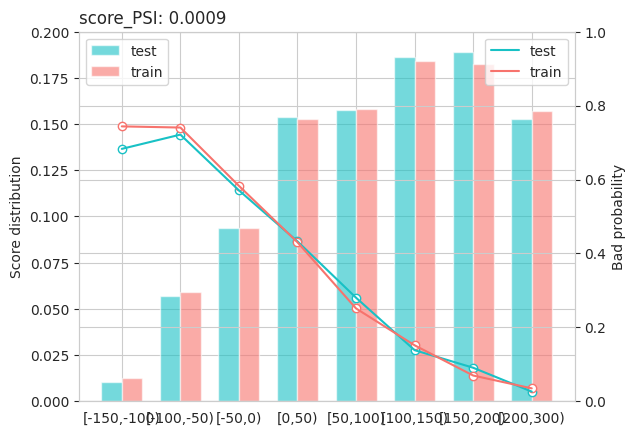

{'psi':   variable       PSI
 0    score  0.000919,
 'pic': {'score': <Figure size 640x480 with 2 Axes>}}

In [199]:
sc.perf_psi(
    score={
        "train": train_score,
        "test": test_score,
    },
    label={
        "train": y_train,
        "test": y_test,
    },
)